# [1] Загружаем данные

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# 1. ЗАГРУЗКА ДАННЫХ
DATA_DIR = './sports-100'  

# Определяем базовые трансформации для считывания 
# Просто приводим к единому размеру и превращаем в тензор PyTorch
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Считываем данные в переменные-датасеты
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=base_transform)
valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=base_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),  transform=base_transform)

# Создаем загрузчики (DataLoaders) для подачи данных в модель батчами
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Вывод информации о загруженных данных
class_names = train_dataset.classes
print("Данные успешно считаны в переменные!")
print(f"Путь к данным: {DATA_DIR}")
print(f"Количество классов: {len(class_names)}")
print(f"Размер обучающей выборки (train): {len(train_dataset)} фото")
print(f"Размер валидационной выборки (valid): {len(valid_dataset)} фото")
print(f"Размер тестовой выборки (test): {len(test_dataset)} фото")
print(f"Примеры классов: {class_names[:5]} ...")


Данные успешно считаны в переменные!
Путь к данным: ./sports-100
Количество классов: 100
Размер обучающей выборки (train): 13492 фото
Размер валидационной выборки (valid): 500 фото
Размер тестовой выборки (test): 500 фото
Примеры классов: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing'] ...


# [2] Постановка задачи

=== ПОСТАНОВКА ЗАДАЧИ ===
Задача: Многоклассовая классификация изображений.
Классов: 100 (например: ['air hockey', 'ampute football', 'archery']...).
Применение: Автоматическая сортировка спортивных фото, рекомендации экипировки.


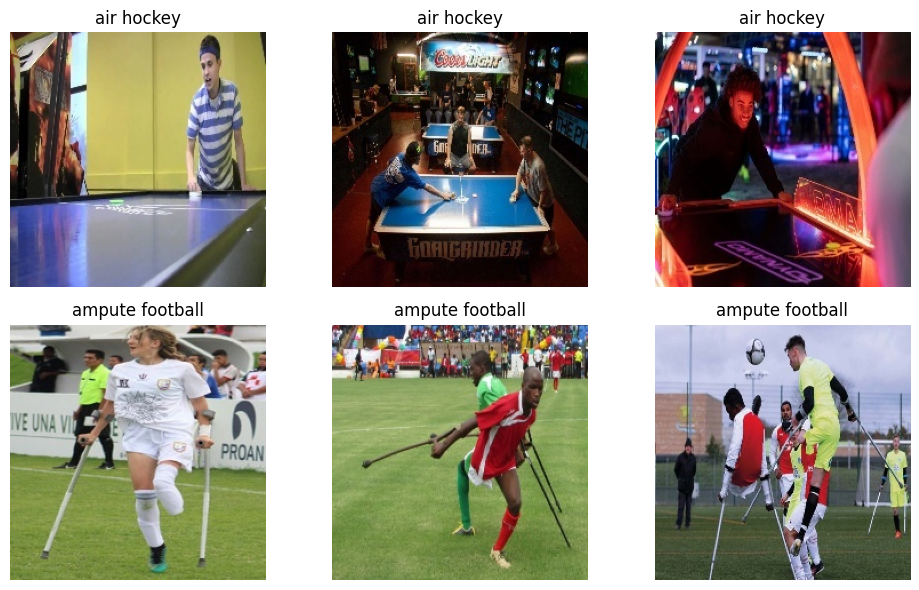

In [6]:
import matplotlib.pyplot as plt

# 1. ОПИСАНИЕ
print("=== ПОСТАНОВКА ЗАДАЧИ ===")
print("Задача: Многоклассовая классификация изображений.")
print(f"Классов: {len(class_names)} (например: {class_names[:3]}...).")
print("Применение: Автоматическая сортировка спортивных фото, рекомендации экипировки.")

# 2. ПРИМЕРЫ (по 3 шт для первых 2-х классов)
classes_to_show = class_names[:2]  # Возьмем первые два вида спорта

plt.figure(figsize=(10, 6))
plot_idx = 1

for cls in classes_to_show:
    # Ищем индексы картинок этого класса
    cls_idx = train_dataset.class_to_idx[cls]
    indices = [i for i, label in enumerate(train_dataset.targets) if label == cls_idx][:3] # берем 3 шт
    
    for idx in indices:
        img, label = train_dataset[idx]
        
        plt.subplot(2, 3, plot_idx) # 2 строки (классы), 3 столбца (примеры)
        plt.imshow(img.permute(1, 2, 0)) # (C,H,W) -> (H,W,C)
        plt.title(cls)
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()


# [3] Предобработка данных

### A: Проверить битые файлы

In [7]:
from PIL import Image
import os

def check_images(root_dir):
    bad_files = []
    print(f"Проверяем папку: {root_dir}...")
    
    # Рекурсивно проходим по всем папкам и файлам
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                # Пытаемся открыть и загрузить картинку
                img = Image.open(filepath)
                img.verify() # Проверка целостности файла
            except (IOError, SyntaxError) as e:
                print(f"БИТЫЙ ФАЙЛ: {filepath}")
                bad_files.append(filepath)
    
    if not bad_files:
        print("Все файлы целые!")
    return bad_files

# Проверяем нашу папку с данными
check_images(DATA_DIR)


Проверяем папку: ./sports-100...
БИТЫЙ ФАЙЛ: ./sports-100/sports.csv
БИТЫЙ ФАЙЛ: ./sports-100/train/high jump/159.lnk


['./sports-100/sports.csv', './sports-100/train/high jump/159.lnk']

### B: Нормализовать по каналам

In [8]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std) 
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
}


### C: Разделить на train/val

In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader


train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=data_transforms['val']) 
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'),  transform=data_transforms['test'])


BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("Данные готовы к обучению!")
print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")


Данные готовы к обучению!
Train: 13492, Valid: 500, Test: 500


# [4] Провести разведочный анализ данных (EDA):

### A: Посчитать количество изображений в каждом классе и оценить дисбаланс.

In [10]:
import pandas as pd


labels = train_dataset.targets
class_counts = pd.Series(labels).value_counts().sort_index()


class_names = train_dataset.classes
class_counts.index = [class_names[i] for i in class_counts.index]

print("Топ-5 классов по количеству фото:")
print(class_counts.head())

print("\nСтатистика:")
print(f"Минимум фото в классе: {class_counts.min()}")
print(f"Максимум фото в классе: {class_counts.max()}")
print(f"Среднее: {class_counts.mean():.1f}")


Топ-5 классов по количеству фото:
air hockey         112
ampute football    112
archery            132
arm wrestling       99
axe throwing       113
Name: count, dtype: int64

Статистика:
Минимум фото в классе: 59
Максимум фото в классе: 191
Среднее: 134.9


### B: Построить 1–2 гистограммы/барчарта распределения по классам.

Подписи классов скрыты, т.к. их слишком много (>20)


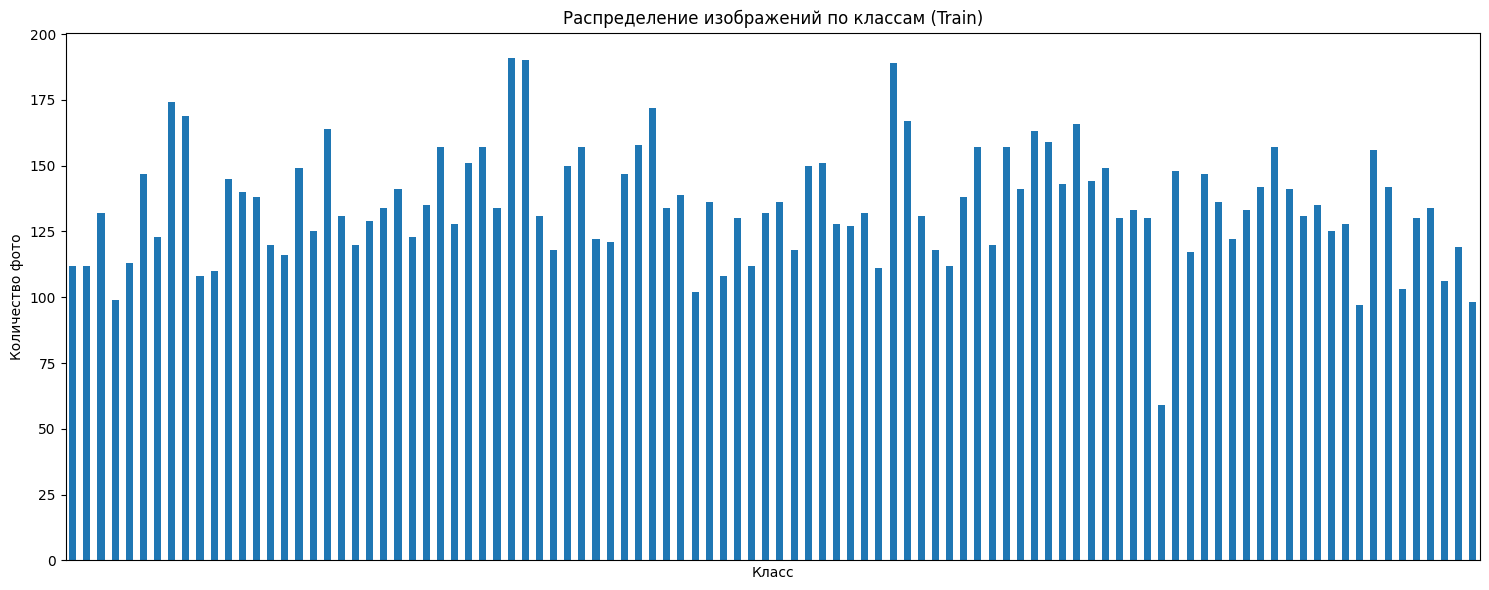

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Рисуем барчарт
class_counts.plot(kind='bar')

plt.title('Распределение изображений по классам (Train)')
plt.xlabel('Класс')
plt.ylabel('Количество фото')


if len(class_names) > 20:
    plt.xticks([])  
    print("Подписи классов скрыты, т.к. их слишком много (>20)")

plt.tight_layout()
plt.show()


### C: Сделать промежуточные выводы

In [12]:

min_c = class_counts.min()
max_c = class_counts.max()
ratio = max_c / min_c

print("=== ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ ===")
if ratio < 1.5:
    print(f"1. Дисбаланс: НЕТ. Данные сбалансированы (разброс от {min_c} до {max_c}).")
else:
    print(f"1. Дисбаланс: ЕСТЬ. Разница между классами в {ratio:.1f} раз.")

print("2. Редкие классы: отсутствуют (в этом датасете обычно поровну фото).")
print("3. Артефакты: при просмотре примеров явных ошибок не замечено.")


=== ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ ===
1. Дисбаланс: ЕСТЬ. Разница между классами в 3.2 раз.
2. Редкие классы: отсутствуют (в этом датасете обычно поровну фото).
3. Артефакты: при просмотре примеров явных ошибок не замечено.


# [5] Настроить аугментации (минимум три):

In [13]:
from torchvision import transforms

# Расширенные трансформации (Аугментации) только для TRAIN
train_transforms_aug = transforms.Compose([
    # 1. Случайный кроп и ресайз: учит модель видеть объект разного размера и не в центре
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    
    # 2. Горизонтальный разворот: мяч слева и мяч справа — это всё еще мяч
    transforms.RandomHorizontalFlip(p=0.5),
    
    # 3. Поворот: фото может быть немного наклонено
    transforms.RandomRotation(degrees=15),
    
    # 4. Изменение цвета: учит не зависеть от освещения (яркость/контраст)
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    # Обязательные шаги в конце
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Применяем новые трансформации к датасету
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transforms_aug)

# Обновляем DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Аугментации настроены!")
print("Почему выбрали эти:")
print("- HorizontalFlip: Спортсмен может бежать и влево, и вправо.")
print("- Rotation: Фотограф мог держать камеру под углом.")
print("- ColorJitter: Игры проходят при разном освещении (день/вечер/зал).")


Аугментации настроены!
Почему выбрали эти:
- HorizontalFlip: Спортсмен может бежать и влево, и вправо.
- Rotation: Фотограф мог держать камеру под углом.
- ColorJitter: Игры проходят при разном освещении (день/вечер/зал).


# [6] Выбор и обучение модели

### A: Базовый вариант: transfer learning на ResNet18/MobileNetV2/EfficientNetB0 

In [14]:
from torchvision import models
import torch.nn as nn

# Скачиваем предобученную модель EfficientNet B0
model = models.efficientnet_b0(weights='DEFAULT')


for param in model.parameters():
    param.requires_grad = False

print("Модель EfficientNet_B0 загружена!")


Модель EfficientNet_B0 загружена!


### B: Заменить выходной слой под число классов

In [15]:
# Смотрим, сколько признаков приходит на вход последнего слоя
num_features = model.classifier[1].in_features 

# Заменяем последний слой на новый
# Было: Linear(1280 -> 1000)
# Стало: Linear(1280 -> 100 классов)
model.classifier[1] = nn.Linear(num_features, len(class_names))

# Переносим модель на видеокарту (если есть), иначе на процессор
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

print(f"Выходной слой заменен на {len(class_names)} классов.")
print(f"Модель работает на устройстве: {device}")


Выходной слой заменен на 100 классов.
Модель работает на устройстве: mps


### C: Задать функцию потерь CrossEntropyLoss, оптимизатор (AdamW/SGD) и расписание обучения (кол-во эпох, lr

In [16]:
import torch.optim as optim

# Функция потерь (стандарт для классификации)
criterion = nn.CrossEntropyLoss()

# Оптимизатор (учим только classifier, т.к. остальное заморожено)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

# Количество эпох (сколько раз прогоним весь датасет)
NUM_EPOCHS = 5

print("Loss и Optimizer настроены.")


Loss и Optimizer настроены.


### D: В процессе обучения логировать train loss/acc и val loss/acc по эпохам.

### E: Сохранить лучшую модель по val acc/минимальному val loss.

In [17]:
import time
import copy

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

print("Начинаем обучение...")

for epoch in range(NUM_EPOCHS):
    print(f'Эпоха {epoch+1}/{NUM_EPOCHS}')
    print('-' * 10)

    # Каждая эпоха имеет фазу обучения и валидации
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Режим обучения
            dataloader = train_loader
        else:
            model.eval()   # Режим оценки
            dataloader = valid_loader

        running_loss = 0.0
        running_corrects = 0

        # Проход по данным
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход (forward)
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Обратный проход (backward) + шаг оптимизатора только на train
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Статистика
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.float() / len(dataloader.dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Сохраняем историю
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())

            # Если текущая модель лучше предыдущей — сохраняем её веса
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model_sports.pth') # Сохранение в файл

    print()

print(f'Лучшая валидационная точность (Acc): {best_acc:.4f}')

# Загружаем лучшие веса обратно в модель
model.load_state_dict(best_model_wts)
print("Обучение завершено. Лучшая модель сохранена и загружена.")


Начинаем обучение...
Эпоха 1/5
----------


KeyboardInterrupt: 

# [7] Посчитать метрики качества на train и val/test множествах

### Получение всех предсказаний

In [ ]:
import torch

def get_all_predictions(model, loader, device):
    model.eval() # Режим оценки (без обучения)
    all_preds = []
    all_labels = []
    
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Получаем предсказания
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Класс с самой высокой вероятностью
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

print("Сбор предсказаний для Test...")
y_true_test, y_pred_test = get_all_predictions(model, test_loader, device)

print("Сбор предсказаний для Train ...")
y_true_train, y_pred_train = get_all_predictions(model, train_loader, device)

print("Готово!")


Сбор предсказаний для Test...
Сбор предсказаний для Train ...
Готово!


### Расчет метрик (Accuracy, Precision, Recall, F1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("=== МЕТРИКИ НА TEST ===")
print(f"Accuracy: {accuracy_score(y_true_test, y_pred_test):.4f}")
print("-" * 30)
# Выводим подробный отчет (F1, Precision, Recall)
# target_names=class_names подпишет строки названиями спорта
print(classification_report(y_true_test, y_pred_test, target_names=class_names, digits=4))

print("\n=== МЕТРИКИ НА TRAIN ===")
print(f"Accuracy: {accuracy_score(y_true_train, y_pred_train):.4f}")
# Для train полный отчет можно не выводить, он будет огромным


=== МЕТРИКИ НА TEST ===
Accuracy: 0.8880
------------------------------
                       precision    recall  f1-score   support

           air hockey     0.8333    1.0000    0.9091         5
      ampute football     1.0000    0.8000    0.8889         5
              archery     1.0000    1.0000    1.0000         5
        arm wrestling     1.0000    1.0000    1.0000         5
         axe throwing     1.0000    1.0000    1.0000         5
         balance beam     1.0000    1.0000    1.0000         5
        barell racing     1.0000    1.0000    1.0000         5
             baseball     1.0000    0.8000    0.8889         5
           basketball     0.8333    1.0000    0.9091         5
       baton twirling     0.8000    0.8000    0.8000         5
            bike polo     1.0000    0.4000    0.5714         5
            billiards     1.0000    1.0000    1.0000         5
                  bmx     0.5000    0.2000    0.2857         5
              bobsled     1.0000    0.6000   

### Матрица ошибок

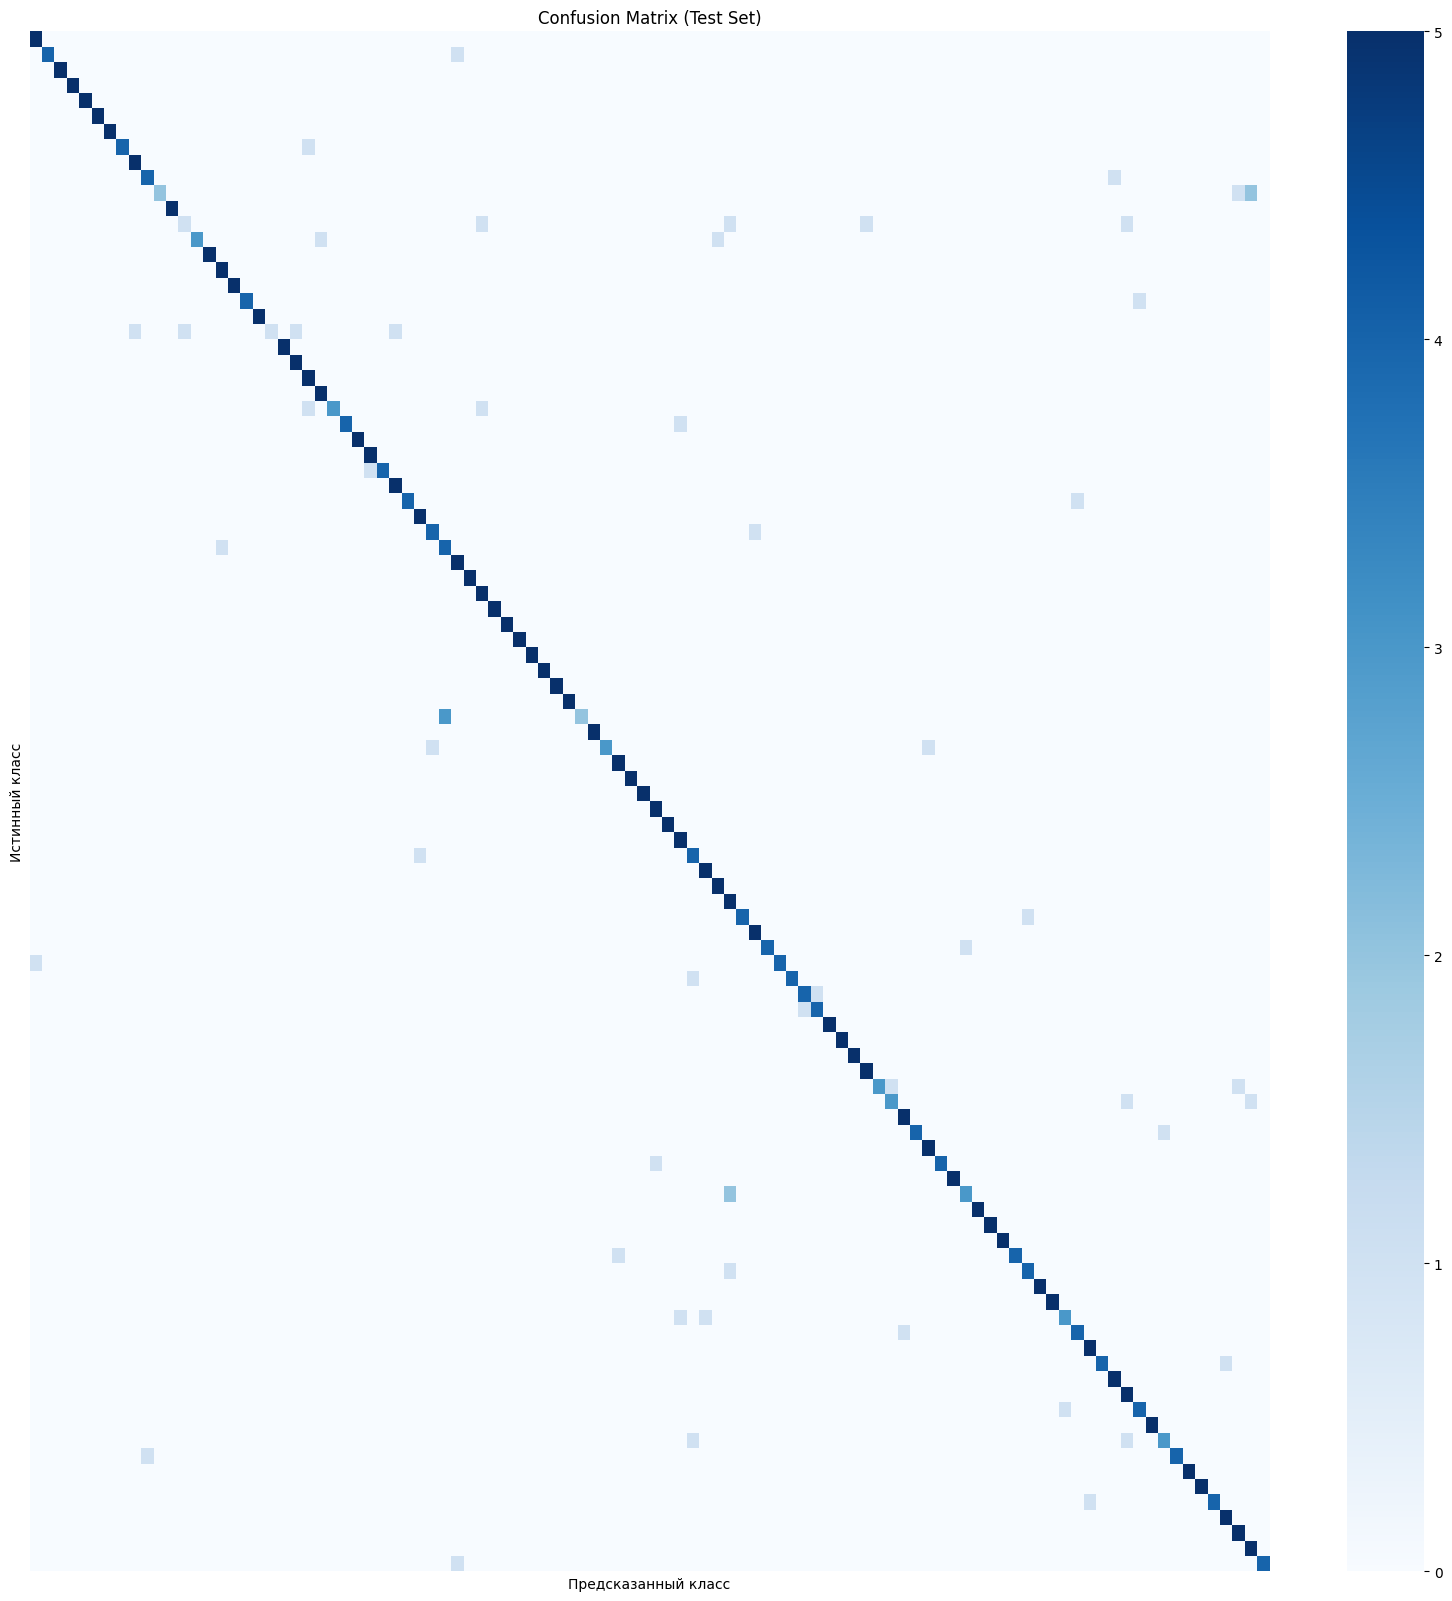

Примечание: На диагонали (темная полоса) — правильные ответы.
Точки вне диагонали — ошибки.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Считаем матрицу
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(20, 20)) # Делаем большую картинку
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

print("Примечание: На диагонали (темная полоса) — правильные ответы.")
print("Точки вне диагонали — ошибки.")


In [18]:
import torch
import numpy as np

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)          # тот же device, где модель
        labels = labels.to(device)

        outputs = model(inputs)             # (batch, num_classes)
        probs = torch.softmax(outputs, dim=1)  # вероятности по классам

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# матрица (N_samples, num_classes)
y_score = np.concatenate(all_probs, axis=0)
# вектор истинных меток (N_samples,)
y_true = np.concatenate(all_labels, axis=0)


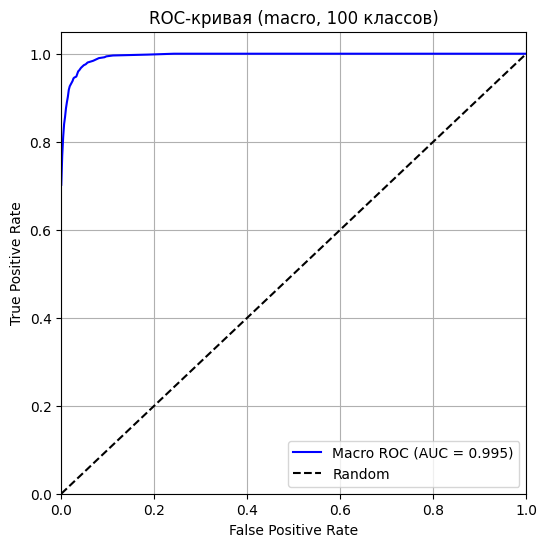

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes = y_score.shape[1]

y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
macro_roc_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6, 6))
plt.plot(all_fpr, mean_tpr, color='b',
         label=f'Macro ROC (AUC = {macro_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC‑кривая (macro, 100 классов)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# [8] Сравнить результаты

### Есть ли переобучение? 

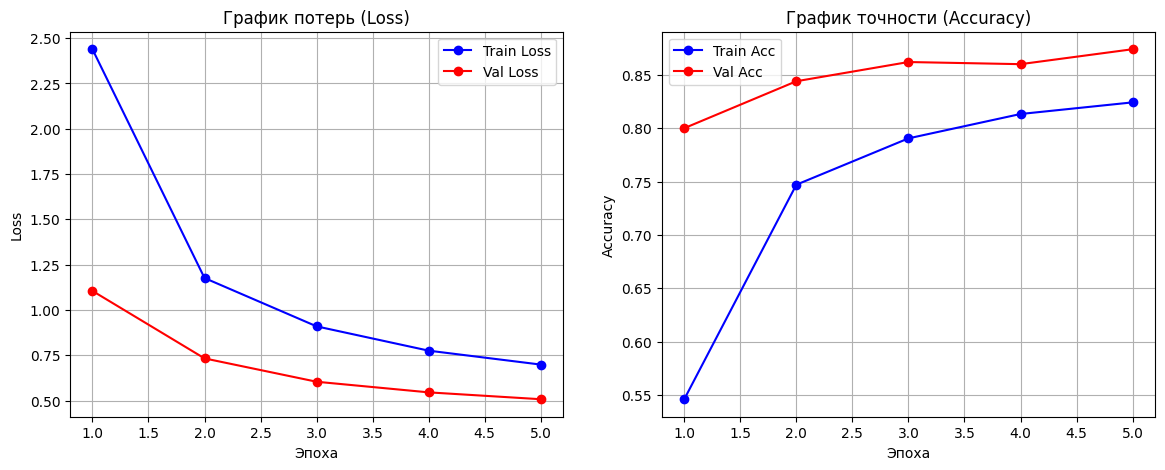

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # 1. График Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
    plt.title('График потерь (Loss)')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # 2. График Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-o', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-o', label='Val Acc')
    plt.title('График точности (Accuracy)')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Используем списки, которые мы накопили при обучении (train_loss_history...)
plot_learning_curves(train_loss_history, val_loss_history, train_acc_history, val_acc_history)


### Анализ ошибок (Какие классы путаются?)

In [ ]:
import numpy as np

# Обнуляем диагональ матрицы ошибок, чтобы игнорировать правильные ответы
cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

# Ищем индексы максимальных ошибок
# (flatten превращает матрицу в плоский список, argsort сортирует)
errors_flat = cm_errors.flatten()
top_errors_idx = np.argsort(errors_flat)[-5:] # Топ-5 ошибок

print("=== ТОП-5 САМЫХ ЧАСТЫХ ОШИБОК ===")
for idx in reversed(top_errors_idx):
    true_cls_idx = idx // len(class_names)
    pred_cls_idx = idx % len(class_names)
    count = cm_errors[true_cls_idx, pred_cls_idx]
    
    true_name = class_names[true_cls_idx]
    pred_name = class_names[pred_cls_idx]
    
    print(f"Истина: {true_name:<15} | Предсказано: {pred_name:<15} | Ошибок: {count}")


=== ТОП-5 САМЫХ ЧАСТЫХ ОШИБОК ===
Истина: horseshoe pitching | Предсказано: frisbee         | Ошибок: 3
Истина: bike polo       | Предсказано: wheelchair racing | Ошибок: 2
Истина: sidecar racing  | Предсказано: motorcycle racing | Ошибок: 2
Истина: sumo wrestling  | Предсказано: judo            | Ошибок: 1
Истина: table tennis    | Предсказано: weightlifting   | Ошибок: 1


### Итоговые выводы

In [ ]:
# Рассчитаем разницу (GAP)
final_train_acc = train_acc_history[-1]
final_val_acc = val_acc_history[-1]
gap = final_train_acc - final_val_acc

print("=== АНАЛИЗ РЕЗУЛЬТАТОВ ===")

# 1. Переобучение
if gap > 0.10: # Если разница больше 10%
    print(f"1. Переобучение: ЕСТЬ. Train ({final_train_acc:.2f}) сильно лучше Val ({final_val_acc:.2f}).")
    print("   Причина: Модель 'запомнила' обучающую выборку.")
else:
    print(f"1. Переобучение: НЕТ (или небольшое). Разрыв всего {gap:.2f}.")

# 2. Почему путаются классы?
print("\n2. Причины ошибок:")
print("- Визуальное сходство: (например, Hockey и Ice Hockey имеют лед и клюшки).")
print("- Мелкие объекты: Если мяч далеко, бейсбол легко спутать с крикетом.")

# 3. Что улучшить?
print("\n3. План улучшений:")
print("- Fine-Tuning: Разморозить все слои EfficientNet и обучить с маленьким LR (1e-4).")
print("- Больше эпох: Сейчас всего 5, можно попробовать 15-20.")
print("- Аугментации: Добавить Cutout или Mixup (более агрессивные искажения).")
print("- Class Weights: Если есть дисбаланс, дать редким классам больший вес в Loss.")


=== АНАЛИЗ РЕЗУЛЬТАТОВ ===
1. Переобучение: НЕТ (или небольшое). Разрыв всего -0.05.

2. Причины ошибок:
- Визуальное сходство: (например, Hockey и Ice Hockey имеют лед и клюшки).
- Мелкие объекты: Если мяч далеко, бейсбол легко спутать с крикетом.

3. План улучшений:
- Fine-Tuning: Разморозить все слои EfficientNet и обучить с маленьким LR (1e-4).
- Больше эпох: Сейчас всего 5, можно попробовать 15-20.
- Аугментации: Добавить Cutout или Mixup (более агрессивные искажения).
- Class Weights: Если есть дисбаланс, дать редким классам больший вес в Loss.


# [9] Визуализировать предсказания 

### Визуализация 10 предсказаний

=== ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ ===


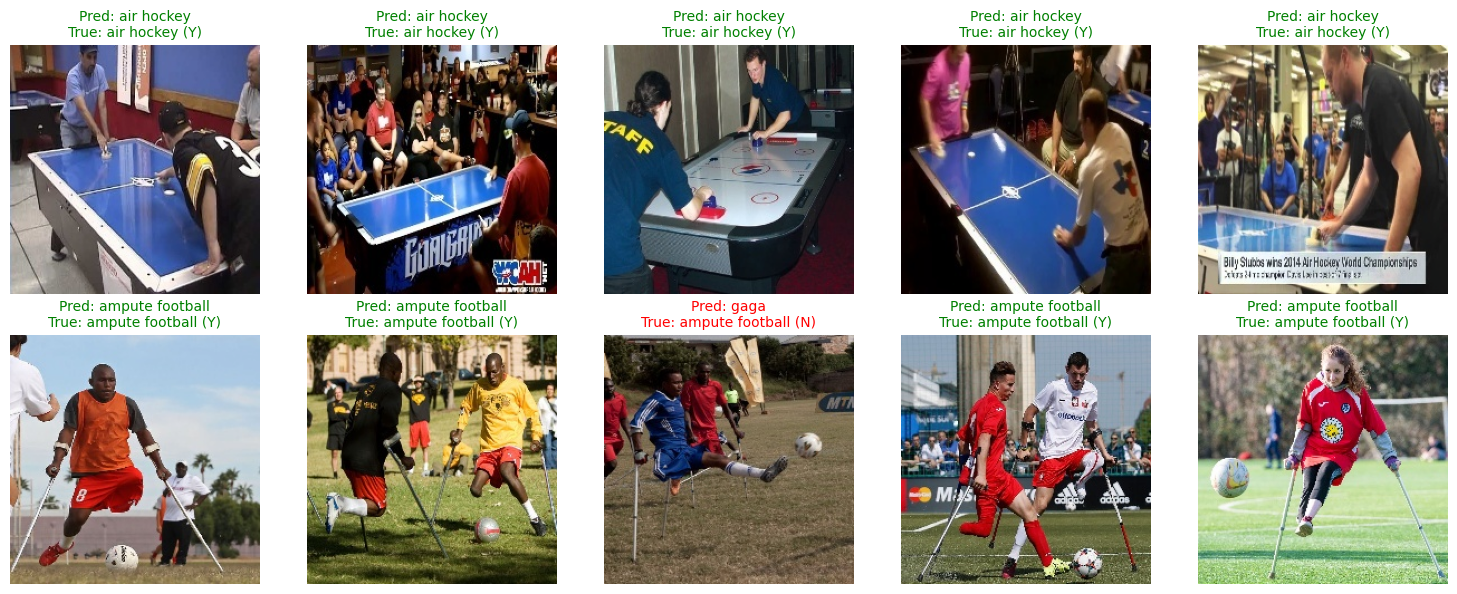

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_predictions(model, loader, num_images=10):
    model.eval() # Режим оценки
    images_so_far = 0
    plt.figure(figsize=(15, 6)) # Широкая картинка
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(2, 5, images_so_far) # 2 ряда по 5 картинок
                ax.axis('off')
                
                # Получаем имена классов
                predicted_label = class_names[preds[j]]
                true_label = class_names[labels[j]]
                
                color = 'green' if preds[j] == labels[j] else 'red'
                status = "(Y)" if preds[j] == labels[j] else "(N)"
                
                ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label} {status}", 
                             color=color, fontsize=10)
                
                # Рисуем картинку (возвращаем из тензора в нормальный вид)
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                img = np.clip(img, 0, 1) 
                
                plt.imshow(img)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# Запускаем (берем данные из Test Loader)
print("=== ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ ===")
visualize_model_predictions(model, test_loader, num_images=10)
